In [1]:
import tensorflow as tf

In [4]:
with tf.io.TFRecordWriter("data/my_data.tfrecord") as f:
    f.write(b"tensorflow demo")
    f.write(b"for tfrecords api")

In [5]:
file_path = ['data/my_data.tfrecord']

dataset = tf.data.TFRecordDataset(file_path)
for item in dataset:
    print(item)

tf.Tensor(b'tensorflow demo', shape=(), dtype=string)
tf.Tensor(b'for tfrecords api', shape=(), dtype=string)


In [6]:
filepaths = ["data/my_test_{}.tfrecord".format(i) for i in range(5)]

for i, filepath in enumerate(filepaths):
    with tf.io.TFRecordWriter(filepath) as f:
        for j in range(3):
            f.write("File {} record {}".format(i,j).encode("utf-8"))

In [7]:
dataset = tf.data.TFRecordDataset(filepaths, num_parallel_reads=3)
for item in dataset:
    print(item)

tf.Tensor(b'File 0 record 0', shape=(), dtype=string)
tf.Tensor(b'File 1 record 0', shape=(), dtype=string)
tf.Tensor(b'File 2 record 0', shape=(), dtype=string)
tf.Tensor(b'File 0 record 1', shape=(), dtype=string)
tf.Tensor(b'File 1 record 1', shape=(), dtype=string)
tf.Tensor(b'File 2 record 1', shape=(), dtype=string)
tf.Tensor(b'File 0 record 2', shape=(), dtype=string)
tf.Tensor(b'File 1 record 2', shape=(), dtype=string)
tf.Tensor(b'File 2 record 2', shape=(), dtype=string)
tf.Tensor(b'File 3 record 0', shape=(), dtype=string)
tf.Tensor(b'File 4 record 0', shape=(), dtype=string)
tf.Tensor(b'File 3 record 1', shape=(), dtype=string)
tf.Tensor(b'File 4 record 1', shape=(), dtype=string)
tf.Tensor(b'File 3 record 2', shape=(), dtype=string)
tf.Tensor(b'File 4 record 2', shape=(), dtype=string)


# Compressed TFRecord Files

In [8]:
options = tf.io.TFRecordOptions(compression_type="GZIP")
with tf.io.TFRecordWriter("data/my_compressed.tfrecord", options) as f:
    f.write(b"Compress, compress, compress!")

In [10]:
dataset = tf.data.TFRecordDataset(["data/my_compressed.tfrecord"],
                                  compression_type="GZIP")
for item in dataset:
    print(item)

tf.Tensor(b'Compress, compress, compress!', shape=(), dtype=string)


# Protobuf

In [5]:
%%writefile person.proto

syntax = 'proto3';
message Person{
    string name = 1;
    int32 id = 2;
    repeated string email = 3;
}

Writing person.proto


Compile

In [6]:
!protoc person.proto --python_out=. --descriptor_set_out=person.desc --include_imports

In [7]:
!dir person*

 Volume in drive C is Windows-SSD
 Volume Serial Number is ECE8-06C9

 Directory of c:\Users\hemch\git\dl-a-z\notebooks\tf_data

25-04-2024  22:50                92 person.desc
25-04-2024  22:50               115 person.proto
25-04-2024  22:50             1,064 person_pb2.py
               3 File(s)          1,271 bytes
               0 Dir(s)  99,386,703,872 bytes free


In [1]:
from person_pb2 import Person

In [3]:
person = Person(name="Hem", email=["hem@gmail"], id = 34)
print(person)

name: "Hem"
id: 34
email: "hem@gmail"



In [4]:
person.name

'Hem'

In [5]:
person.email.append("hem@yahoo")

In [6]:
serialized_person = person.SerializeToString()
serialized_person

b'\n\x03Hem\x10"\x1a\them@gmail\x1a\them@yahoo'

In [7]:
person2 = Person()
person2.ParseFromString(serialized_person)

29

In [8]:
person == person2

True

## Custom protobuf

In [9]:
import tensorflow as tf
person_tf = tf.io.decode_proto(
    bytes= serialized_person,
    message_type="Person",
    field_names= ["name","id","email"],
    output_types=[tf.string, tf.int32, tf.string],
    descriptor_source="person.desc"
)

In [10]:
person_tf.values

[<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Hem'], dtype=object)>,
 <tf.Tensor: shape=(1,), dtype=int32, numpy=array([34])>,
 <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'hem@gmail', b'hem@yahoo'], dtype=object)>]

# TensorFlow Protobufs

main class of protobuf used in tfrecords is Example which represents one instance in dataset

``` 
syntax = "proto3";
message BytesList { repeated bytes value = 1; }
message FloatList { repeated float value = 1 [packed = true]; }
message Int64List { repeated int64 value = 1 [packed = true]; }
message Feature {
    oneof kind {
        BytesList bytes_list = 1;
        FloatList float_list = 2;
        Int64List int64_list = 3;
    }
};
message Features { map<string, Feature> feature = 1; };
message Example { Features features = 1; };
```

In [11]:
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Feature, Features, Example

person_example = Example(
    features = Features(
        feature = {
            "name": Feature(bytes_list=BytesList(value=[b"Hem"])),
            "id": Feature(int64_list=Int64List(value=[123])),
            "emails": Feature(bytes_list=BytesList(value=[b"hem@gmail", b"hem@yahoo"]))
        }
    )
)

In [12]:
person_example

features {
  feature {
    key: "name"
    value {
      bytes_list {
        value: "Hem"
      }
    }
  }
  feature {
    key: "id"
    value {
      int64_list {
        value: 123
      }
    }
  }
  feature {
    key: "emails"
    value {
      bytes_list {
        value: "hem@gmail"
        value: "hem@yahoo"
      }
    }
  }
}

In [13]:
import tensorflow as tf

with tf.io.TFRecordWriter("data/simple_person.tfrecord") as f:
    for _ in range(5):
        f.write(person_example.SerializeToString())

# loading the file back

In [15]:
feature_description = {
    "name": tf.io.FixedLenFeature([], tf.string, default_value=""),
    "id":  tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "emails": tf.io.VarLenFeature(tf.string),
}

def parse(serialized_example):
    return tf.io.parse_single_example(serialized_example, feature_description)

dataset = tf.data.TFRecordDataset("data/simple_person.tfrecord").map(parse)

for parsed_line in dataset:
    print(parsed_line)

{'emails': SparseTensor(indices=tf.Tensor(
[[0]
 [1]], shape=(2, 1), dtype=int64), values=tf.Tensor([b'hem@gmail' b'hem@yahoo'], shape=(2,), dtype=string), dense_shape=tf.Tensor([2], shape=(1,), dtype=int64)), 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>, 'name': <tf.Tensor: shape=(), dtype=string, numpy=b'Hem'>}
{'emails': SparseTensor(indices=tf.Tensor(
[[0]
 [1]], shape=(2, 1), dtype=int64), values=tf.Tensor([b'hem@gmail' b'hem@yahoo'], shape=(2,), dtype=string), dense_shape=tf.Tensor([2], shape=(1,), dtype=int64)), 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>, 'name': <tf.Tensor: shape=(), dtype=string, numpy=b'Hem'>}
{'emails': SparseTensor(indices=tf.Tensor(
[[0]
 [1]], shape=(2, 1), dtype=int64), values=tf.Tensor([b'hem@gmail' b'hem@yahoo'], shape=(2,), dtype=string), dense_shape=tf.Tensor([2], shape=(1,), dtype=int64)), 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>, 'name': <tf.Tensor: shape=(), dtype=string, numpy=b'Hem'>}
{'emails': SparseTensor(indices=tf

In [16]:
tf.sparse.to_dense(parsed_line["emails"], default_value=b"")

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'hem@gmail', b'hem@yahoo'], dtype=object)>

In [20]:
def parse(serialized_examples):
    return tf.io.parse_example(serialized_examples, feature_description)

dataset = tf.data.TFRecordDataset(["data/simple_person.tfrecord"]).batch(2).map(parse)
for parsed_examples in dataset:
    print(parsed_examples)  # two examples at a time

{'emails': SparseTensor(indices=tf.Tensor(
[[0 0]
 [0 1]
 [1 0]
 [1 1]], shape=(4, 2), dtype=int64), values=tf.Tensor([b'hem@gmail' b'hem@yahoo' b'hem@gmail' b'hem@yahoo'], shape=(4,), dtype=string), dense_shape=tf.Tensor([2 2], shape=(2,), dtype=int64)), 'id': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([123, 123], dtype=int64)>, 'name': <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'Hem', b'Hem'], dtype=object)>}
{'emails': SparseTensor(indices=tf.Tensor(
[[0 0]
 [0 1]
 [1 0]
 [1 1]], shape=(4, 2), dtype=int64), values=tf.Tensor([b'hem@gmail' b'hem@yahoo' b'hem@gmail' b'hem@yahoo'], shape=(4,), dtype=string), dense_shape=tf.Tensor([2 2], shape=(2,), dtype=int64)), 'id': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([123, 123], dtype=int64)>, 'name': <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'Hem', b'Hem'], dtype=object)>}
{'emails': SparseTensor(indices=tf.Tensor(
[[0 0]
 [0 1]], shape=(2, 2), dtype=int64), values=tf.Tensor([b'hem@gmail' b'hem@yahoo'], shape=(

In [21]:
parsed_examples

{'emails': SparseTensor(indices=tf.Tensor(
 [[0 0]
  [0 1]], shape=(2, 2), dtype=int64), values=tf.Tensor([b'hem@gmail' b'hem@yahoo'], shape=(2,), dtype=string), dense_shape=tf.Tensor([1 2], shape=(2,), dtype=int64)),
 'id': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([123], dtype=int64)>,
 'name': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Hem'], dtype=object)>}

# Storing Images and Tensors in TFRecords

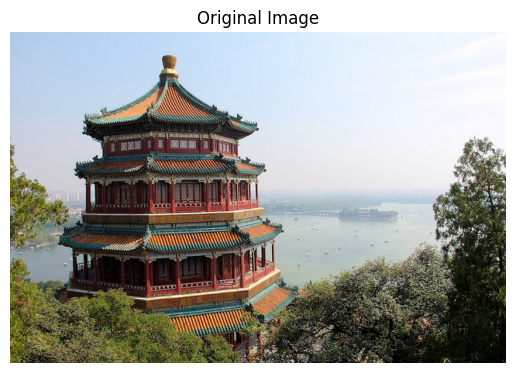

In [22]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_sample_images

img = load_sample_images()["images"][0]
plt.imshow(img)
plt.axis("off")
plt.title("Original Image")
plt.show()

## Serialize image

In [23]:
data = tf.io.encode_jpeg(img)
example_with_image = Example(features=Features(feature={
    "image": Feature(bytes_list=BytesList(value=[data.numpy()]))}))
serialized_example = example_with_image.SerializeToString()
with tf.io.TFRecordWriter("data/my_image.tfrecord") as f:
    f.write(serialized_example)

## Read image

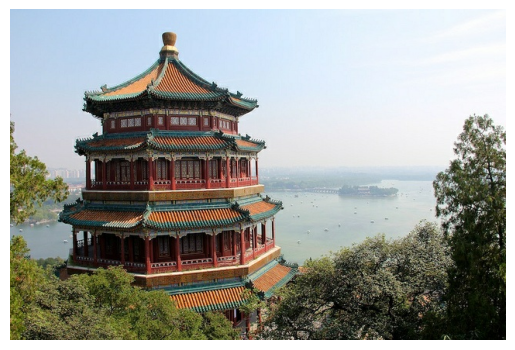

In [24]:
feature_description = { "image": tf.io.VarLenFeature(tf.string) }

def parse(serialized_example):
    example_with_image = tf.io.parse_single_example(serialized_example,
                                                    feature_description)
    return tf.io.decode_jpeg(example_with_image["image"].values[0])
    # or you can use tf.io.decode_image() instead

dataset = tf.data.TFRecordDataset("data/my_image.tfrecord").map(parse)
for image in dataset:
    plt.imshow(image)
    plt.axis("off")
    plt.show()